In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"winnerdebofan","key":"2a7a5d85ad4bfff98ea8c49f83c960ed"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json  

In [6]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 60% 28.0M/47.0M [00:00<00:00, 143MB/s] 
100% 47.0M/47.0M [00:00<00:00, 168MB/s]


In [7]:
! unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflatin

# **Import Packages**

In [8]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.layers as layers
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix 

In [9]:
filepath = '/content/Shoe vs Sandal vs Boot Dataset'
test_size = 0.2
dev_size = 0.2
n_H = 102
n_W = 136
epochs = 30
learning_rate=0.0007
random.seed(6278)

# **Import Data**

In [10]:
X = []
Y = []

for shoe_folder in os.scandir(filepath): # iterate through subfolders
    shoe_type = os.path.basename(shoe_folder) # Save folder name string for use as shoe label
    pbar = tqdm(os.scandir(shoe_folder.path), total=5000) # Use tqdm iter to display progress of reading in images
    
    for file in pbar: # iterate through files
        pbar.set_description(f"Processing {shoe_type} Images")
        img = cv2.imread(file.path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # transform defualt read in of cv2 BGR to RGB
        img_array = np.asarray(img)
        
        if img_array.shape != (102,136,3): # Do conditional resizing to save computing power
            img_array = resize(img_array, [n_H,n_W], anti_aliasing=True) # resize to ensure all images are 136 x 102
            
        X.append(img_array)
        Y.append(shoe_type)

Processing Boot Images: 100%|██████████| 5000/5000 [00:15<00:00, 314.63it/s]


In [11]:
X_Y = list(zip(X,Y)) # Zip images and associated label
random.shuffle(X_Y) # Shuffle
X, Y = zip(*X_Y) # Unzip back into X and Y

# **Memvisualisasi gambar yang diambil secara acak**

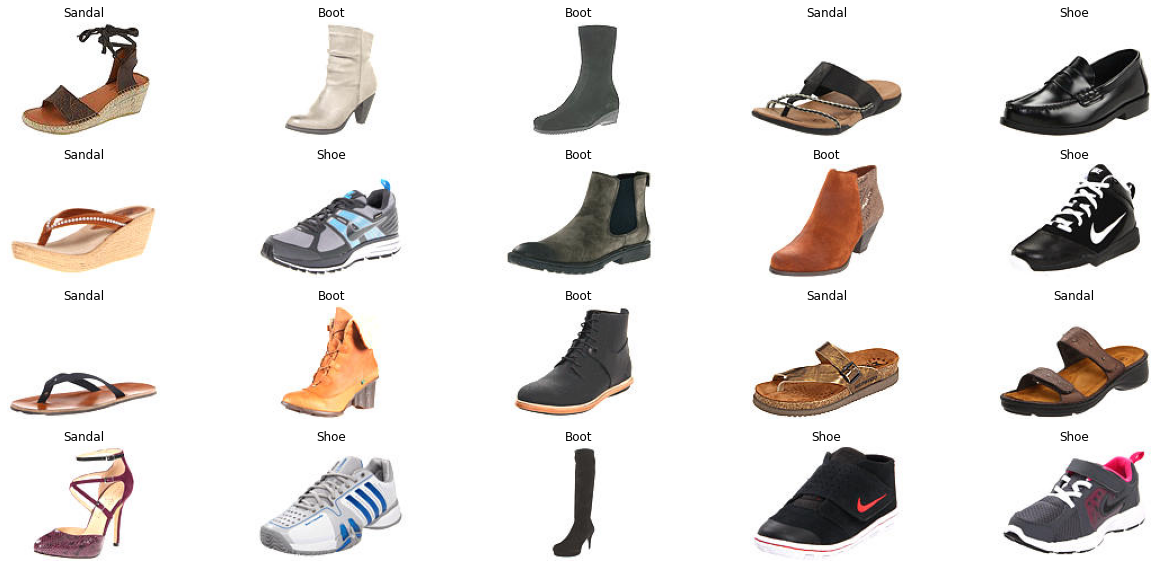

In [12]:
fig, axs = plt.subplots(4,5, figsize=[18,8])
for i in range(20):
    ax = axs[i//5, i%5]
    ax.imshow(X[i])
    ax.axis('off')
    ax.set_title(Y[i])
    
fig.tight_layout()
fig.show()

# **Split Data into Train-Dev-Test**

In [13]:
num_dev = int(len(X) * dev_size) 
num_test = int(len(X) * test_size)

X_arr = np.asarray(X) / 255
Y_arr = np.asarray(Y).reshape(-1,1)

del X, Y

ohe = OneHotEncoder(categories='auto', sparse=False)
Y_ohe = ohe.fit_transform(Y_arr)

X_train = X_arr[:-(num_test + num_dev)]
X_dev = X_arr[-(num_test + num_dev):-num_test]
X_test = X_arr[-num_test:]

Y_train = Y_ohe[:-(num_test + num_dev)]
Y_dev = Y_ohe[-(num_test + num_dev):-num_test]
Y_test = Y_ohe[-num_test:]

del X_arr, Y_arr, Y_ohe

print("Training X:", X_train.shape)
print("Training Y:", Y_train.shape)
print("Development X:", X_dev.shape)
print("Development Y:", Y_dev.shape)
print("Test X:", X_test.shape)
print("Test Y:", Y_test.shape)

Training X: (9000, 102, 136, 3)
Training Y: (9000, 3)
Development X: (3000, 102, 136, 3)
Development Y: (3000, 3)
Test X: (3000, 102, 136, 3)
Test Y: (3000, 3)


# **Membuat Model Convolution Neural Network**

In [14]:
model = tf.keras.Sequential(name = 'FirstModel')

model.add(layers.Conv2D(
    filters=8,
    kernel_size=7,
    activation='relu',
    strides=2,
    padding='same',
    input_shape=(n_H, n_W, 3),
    name='Conv1'))

model.add(layers.MaxPool2D(
    pool_size=(2, 2),
    strides=None,
    padding='same',
    name='MaxPool1'))

model.add(layers.Conv2D(
    filters=16, 
    kernel_size=3, 
    activation='relu', 
    strides=1, 
    padding='valid',
    name='Conv2'))

model.add(layers.MaxPool2D(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    name='MaxPool2'))

model.add(layers.Dropout(.2, name='Dropout1'))

model.add(layers.Conv2D(
    filters=32, 
    kernel_size=5, 
    activation='relu', 
    strides=1, 
    padding='same',
    name='Conv3'))

model.add(layers.MaxPool2D(
    pool_size=(2, 2), 
    strides=None,
    padding='valid',
    name='MaxPool3'))

model.add(layers.Flatten(name='Flatten'))

model.add(layers.Dropout(.2, name='Dropout2'))

model.add(layers.Dense(128,activation='relu',name='Dense1'))

model.add(layers.Dropout(.2, name='Dropout3'))

model.add(layers.Dense(32, activation='relu', name='Dense2'))

model.add(layers.Dense(3, activation='softmax', name='Dense3'))

model.summary()

Model: "FirstModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 51, 68, 8)         1184      
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 26, 34, 8)         0         
                                                                 
 Conv2 (Conv2D)              (None, 24, 32, 16)        1168      
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 12, 16, 16)        0         
                                                                 
 Dropout1 (Dropout)          (None, 12, 16, 16)        0         
                                                                 
 Conv3 (Conv2D)              (None, 12, 16, 32)        12832     
                                                                 
 MaxPool3 (MaxPooling2D)     (None, 6, 8, 32)          0

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=epochs)

Epoch 1/30
282/282 [==============================] - 45s 156ms/step - loss: 0.5121 - accuracy: 0.7769 - val_loss: 0.2491 - val_accuracy: 0.9110
Epoch 2/30
282/282 [==============================] - 44s 155ms/step - loss: 0.2427 - accuracy: 0.9109 - val_loss: 0.1721 - val_accuracy: 0.9443
Epoch 3/30
282/282 [==============================] - 45s 158ms/step - loss: 0.1839 - accuracy: 0.9350 - val_loss: 0.1435 - val_accuracy: 0.9497
Epoch 4/30
282/282 [==============================] - 45s 160ms/step - loss: 0.1530 - accuracy: 0.9483 - val_loss: 0.1315 - val_accuracy: 0.9507
Epoch 5/30
282/282 [==============================] - 44s 156ms/step - loss: 0.1307 - accuracy: 0.9543 - val_loss: 0.1136 - val_accuracy: 0.9603
Epoch 6/30
282/282 [==============================] - 44s 155ms/step - loss: 0.1094 - accuracy: 0.9629 - val_loss: 0.1031 - val_accuracy: 0.9693
Epoch 7/30
282/282 [==============================] - 44s 157ms/step - loss: 0.0971 - accuracy: 0.9660 - val_loss: 0.0905 - val_ac

# **Summarize Results**

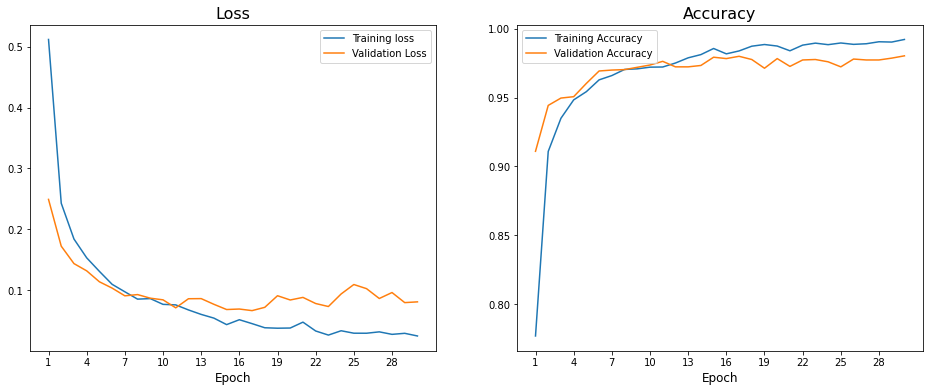

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1,epochs+1), history.history['loss'], label='Training loss')
ax1.plot(range(1,epochs+1), history.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1,epochs+1,3))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1,epochs+1), history.history['accuracy'], label='Training Accuracy')
ax2.plot(range(1,epochs+1), history.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1,epochs+1,3))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [17]:
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

94/94 [==============================] - 4s 45ms/step - loss: 0.0654 - accuracy: 0.9807
Test loss: 0.06535422056913376
Test accuracy: 0.9806666374206543


# **Error Analysis**

In [18]:
Y_pred = model.predict(X_test)
Y_pred_max = Y_pred.max(axis=1,keepdims=True)
Y_pred = (Y_pred_max == Y_pred).astype(int)
Y_test_labels = ohe.inverse_transform(Y_test)
Y_pred_labels = ohe.inverse_transform(Y_pred)

94/94 [==============================] - 4s 43ms/step


,Shoe_pred,Sandal_pred,Boot_pred
Shoe_true,97.390397,1.252610,1.356994
Sandal_true,1.399254,97.761194,0.839552
Boot_true,0.515464,0.412371,99.072165


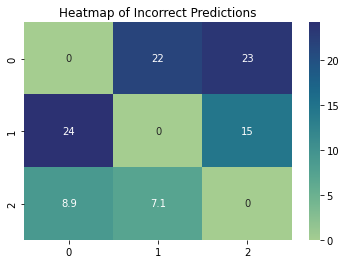

In [19]:
labels = labels=["Shoe", "Sandal", "Boot"]
cm = confusion_matrix(Y_test_labels, Y_pred_labels, labels=labels, normalize='true') * 100



CM = pd.DataFrame(cm,
                  columns = [label+'_pred' for label in labels],
                  index = [label+'_true' for label in labels]).copy()

np.fill_diagonal(cm, 0)
cm = cm *100 / cm.sum()
sns.heatmap(cm, annot=True, cmap="crest")
plt.title('Heatmap of Incorrect Predictions')

CM

In [20]:
prediction_df = pd.DataFrame(zip(Y_pred_labels[:,0], Y_test_labels[:,0]), columns=['Pred', 'True'])
prediction_df['Correct'] = prediction_df['Pred'] == prediction_df['True']
incorrect_predictions = list(prediction_df[prediction_df['Correct'] == False].index)

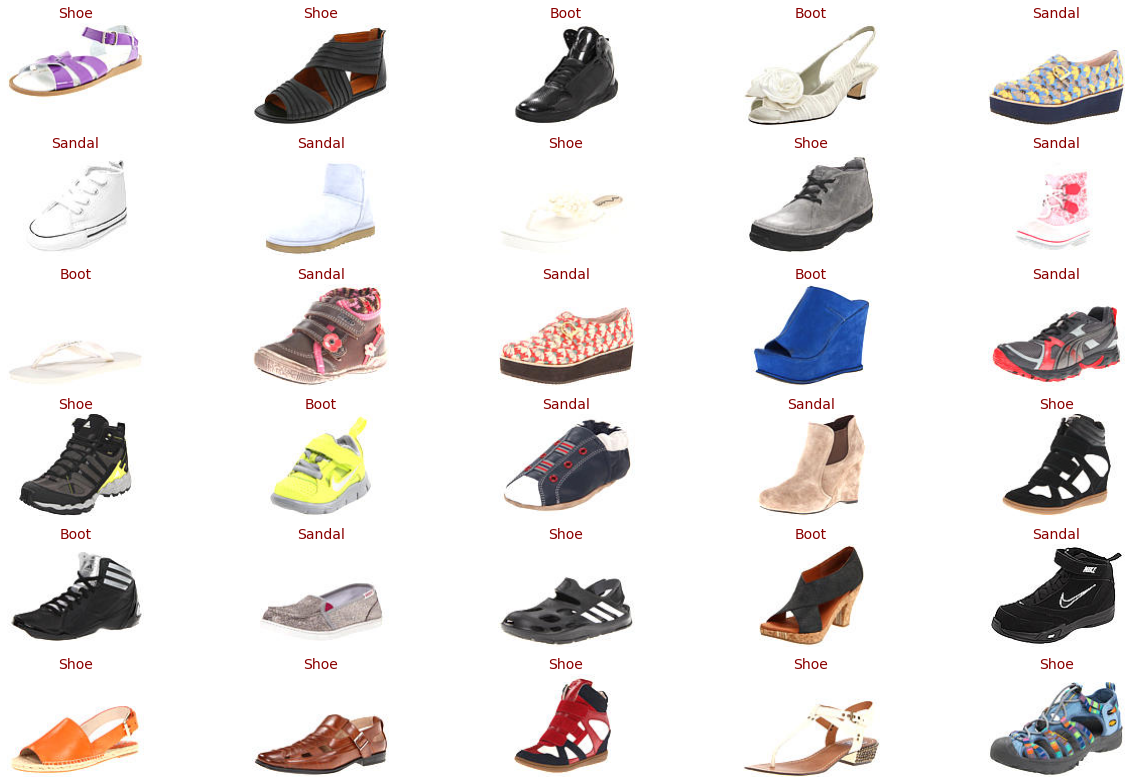

In [21]:
fig, axs = plt.subplots(6,5, figsize=[18,11])
for i, inpred in enumerate(incorrect_predictions[:30]):
    ax = axs[i//5, i%5]
    ax.imshow(X_test[inpred])
    ax.axis('off')
    ax.set_title(Y_pred_labels[inpred][0], fontsize=14, color="darkred")
    
fig.tight_layout()
fig.show()